In [1]:
from train import *
# from compare import *
from statistics import mode
from nested_lookup import nested_lookup
from predict import *
from visualise import *
import seaborn as sn
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif

<h3>Decision Tree</h3>

In [2]:
def decision_tree_acc(test_data,model):
	print("Accuracy")
	print(prediction_accuracy(test_data,model)[0]['Accuracy'] * 100)
	show_heatmap(prediction_accuracy(test_data,model)[1])

<h3>Pre-Defined 

In [3]:
def convert_first(class_list):
	class_dict = {"recurrence-events":1,"no-recurrence-events":0}
	class_list = [class_dict[item] for item in class_list]
	return class_list

def convert(class_list):
	class_unique = np.unique(class_list)
	class_dict = {}
	for index in range(len(class_unique)):
		class_dict[class_unique[index]] = index

	class_list =  [class_dict[item] for item in class_list]
	return class_list




In [4]:
def accuracy(TP,TN,FP,FN):
	numerator = TP + TN
	denominator = TP + TN + FP + FN
	return numerator/denominator
	

# When it actually says, i.e real data
#how often does it predict yes
def recall(TP,FN):
  return TP/(TP+FN)


#When it predicts yes , how often
def precision(TP,FP):
	return TP/(TP+FP)




def f_measure(recall,precision):
	numerator = 2* recall * precision
	denominator = recall + precision
	return numerator / denominator



def prediction_accuracy(test_data,model):

	# Collect all the predictions
	prediction_list = predict_dataset(model,test_data)
	convert_pred = convert(prediction_list)
	# # Collect the actual values
	actual = list(test_data.iloc[:,-1])
	convert_act = convert(actual)

	data = {"y_act":convert_act,"y_pred":convert_pred}
	df = pd.DataFrame(data,columns = ["y_act","y_pred"])
	conf_matrix = pd.crosstab(df["y_act"],df["y_pred"],rownames=["Actual"],colnames=["Predicted"],margins=True,margins_name="Total")
	TP = conf_matrix[1][1]
	TN = conf_matrix[0][0]
	FP = conf_matrix[1][0]
	FN = conf_matrix[0][1]
	acc = accuracy(TP,TN,FP,FN)
	recall_data = recall(TP,FN)
	precision_data = precision(TP,FP)
	f_measure_data = f_measure(recall_data,precision_data)
	return [{"Accuracy":acc, "Recall":recall_data,"Precision":precision_data,"F Measure":f_measure_data},conf_matrix]





def show_heatmap(conf_matrix):
	sn.heatmap(conf_matrix,annot=True)
	plt.title("Breast Cancer: Confusion Matrix")
	plt.show()


In [5]:
def draw(parent_name, child_name):
    edge = pydot.Edge(parent_name, child_name)
    graph.add_edge(edge)


def visit(node, parent=None):
    for k,v in node.items():
        if isinstance(v, dict):      
            if parent:
                draw(parent, k)
            visit(v, k)
        else:
            draw(parent, k)         
            draw(k, k+'_'+v)

In [7]:
def organize_dataset(csv,features,p_features):
        dataset = pd.read_csv(csv, header=None, names=features)
        if True in ["?" in list(dataset[x].unique()) for x in dataset.columns]:
            dataset = dataset[features].replace("?", np.NaN)
        return dataset[p_features]
    
def reorganize_dataset(dataset,missing_value):
        dataset = dataset.drop('Class', 1)
        new_features = list(dataset.columns)
        f_index = new_features.index(missing_value)
        new_features[f_index], new_features[-1] = new_features[-1], new_features[f_index]
        return new_features    

def drop_values(dataset):
    return dataset.dropna(how="any")
    
    
def split_reorganized_dataset(dataset,missing_value):
        train_filter = dataset[missing_value] != "?"
        test_filter = dataset[missing_value] == "?"
        train_dataset = dataset[train_filter]
        test_dataset = dataset[test_filter]
        train_class_values = train_dataset.loc[:, 'Class']
        test_class_values = test_dataset.loc[:, 'Class']
        return train_dataset, test_dataset, train_class_values, test_class_values

def input_value_into_test_dataset(x_test,missing_value,predicted_values):
        dataset = x_test.drop(missing_value, 1)
        cols = len(x_test.columns)
        dataset.insert(cols - 1, missing_value, predicted_values)
        return dataset
    
def merge_datasets(x_train,x_test,c_train,c_test,re_features,p_features,missed_value):
        x_train = x_train[re_features]
        x_test = x_test[re_features]
        model = ID3(x_train,x_train)
        predicted_values = predict_dataset(model,x_test)
        new_xtest = input_value_into_test_dataset(x_test,missed_value,predicted_values)
        new_training_data = pd.concat([x_train, c_train], axis=1)
        new_testing_data = pd.concat([new_xtest, c_test], axis=1)
        new_dataset = pd.concat([new_training_data, new_testing_data], axis=0)
        return new_dataset.sort_index()[p_features]
    
def split_dataset(dataset):
    split = len(dataset) * 70//100
    train_data = dataset[:split]
    test_data = dataset[split:]
    return train_data,test_data

In [9]:
class Decision_Tree:
    def __init__(self):
        self.p_features = ["Irradiat","Age","Menopause","Tumor-Size","Inv-Node","Node-Caps","Deg-Malig","Breast","Breast-Quad","Class"]
        self.missing_values = ["Node-Caps","Breast-Quad"]
        self.missing_value = self.missing_values[0]
    
    def fill_most(self,dataset):
        node_caps_top =  dataset['Node-Caps'].describe()['top']
        breast_quad_top = dataset['Breast-Quad'].describe()['top']
        tops = [node_caps_top,breast_quad_top]
        for missing_value,top in zip(self.missing_values,tops):
            if dataset[missing_value].isnull().sum() > 0:
                dataset[missing_value].replace(np.NaN,top,inplace=True)
        return dataset
    
    

   
        

<h3>Applying Feature Imputation To The Datasets</h3>

<h3> Feature Selection </h3>

In [10]:
features = ["Class","Age","Menopause","Tumor-Size","Inv-Node","Node-Caps","Deg-Malig","Breast","Breast-Quad","Irradiat"]
p_features = ["Irradiat","Age","Menopause","Tumor-Size","Inv-Node","Node-Caps","Deg-Malig","Breast","Breast-Quad","Class"]
csv = 'breast-cancer.csv'
dt = Decision_Tree()
#Original Dataset
dataset = pd.read_csv(csv, header=None, names=features)[p_features]
mix_dataset = dataset.sample(frac=1)

##Fill Most Dataset
fill_most_dataset = dt.fill_most(organize_dataset(csv,features,p_features))
mix_fill_most_dataset = dataset.sample(frac=1)

#Drop Dataset
drop_dataset = drop_values(organize_dataset(csv,features,p_features))
mix_drop_dataset = drop_dataset.sample(frac=1)

##Classifier Dataset
x_train, x_test, c_train, c_test = split_reorganized_dataset(dataset,"Node-Caps")
re_features = reorganize_dataset(dataset,"Node-Caps")
classifier_dataset = merge_datasets(x_train,x_test,c_train,c_test,re_features,p_features,"Node-Caps")
mix_classifier_dataset = classifier_dataset.sample(frac=1)

In [12]:
# features = ["Class","Age","Menopause","Tumor-Size","Inv-Node","Node-Caps","Deg-Malig","Breast","Breast-Quad","Irradiat"]
fs_features =  ["Irradiat","Tumor-Size","Inv-Node","Node-Caps","Deg-Malig","Class"]
fs_dataset = mix_drop_dataset[fs_features]

In [13]:
#Original Dataset
train_mix_dataset,test_mix_dataset = split_dataset(mix_dataset)

# Drop dataset
train_mix_drop_dataset,test_mix_drop_dataset = split_dataset(mix_drop_dataset)

#Fill Most Dataset
train_mix_fill_most_dataset,test_mix_fill_most_dataset = split_dataset(mix_fill_most_dataset)

#Classifier Dataset
train_mix_classifier_dataset,test_mix_classifier_dataset = split_dataset(mix_classifier_dataset)

train_fs_dataset,test_fs_dataset = split_dataset(fs_dataset)

<h3> Decision Tree and Accuracy </h3>
<h4> Feature Imputation: Method 1: Drop Missing Values</h4>
<h4>vs</h4>
<h4> Feature Selected Imputation </h4>

Accuracy
65.47619047619048


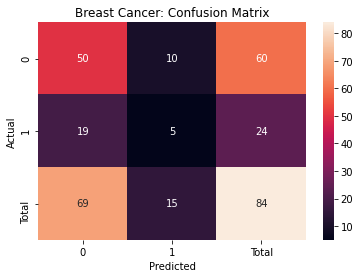

Accuracy
67.85714285714286


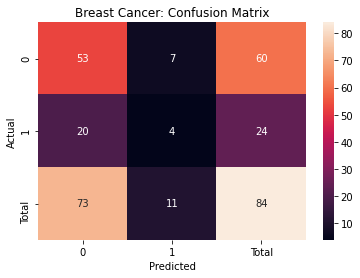

In [14]:
drop_model = ID3(train_mix_drop_dataset,train_mix_drop_dataset)
drop_model_accuracy = decision_tree_acc(test_mix_drop_dataset,drop_model)

#Feature Selected
fs_drop_model = ID3(train_mix_drop_dataset[fs_features],train_mix_drop_dataset[fs_features])
fs_drop_model_accuracy = decision_tree_acc(test_mix_drop_dataset[fs_features],fs_drop_model)

<h3> Decision Tree and Accuracy </h3>
<h4> Feature Imputation: Method 2: Fill Missing Values</h4>
<h4>vs</h4>
<h4> Feature Selected Imputation </h4>

Accuracy
65.11627906976744


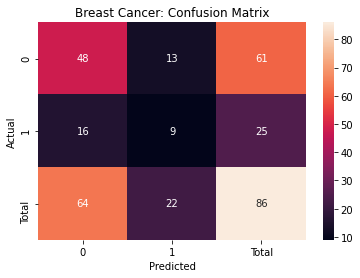

Accuracy
66.27906976744185


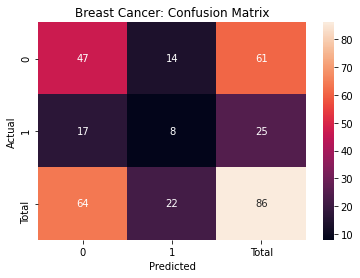

In [18]:
fill_model = ID3(train_mix_fill_most_dataset,train_mix_fill_most_dataset)
fill_model_accuracy = decision_tree_acc(test_mix_fill_most_dataset,fill_model)

#Feature Selected
fs_fill_model = ID3(train_mix_fill_most_dataset[fs_features],train_mix_fill_most_dataset[fs_features])
fs_fill_model_accuracy = decision_tree_acc(test_mix_fill_most_dataset[fs_features],fs_fill_model)

<h3> Decision Tree and Accuracy </h3>
<h4> Feature Imputation: Method 3: Classify Values</h4>
<h4>vs</h4>
<h4> Feature Selected Imputation </h4>

Accuracy
63.95348837209303


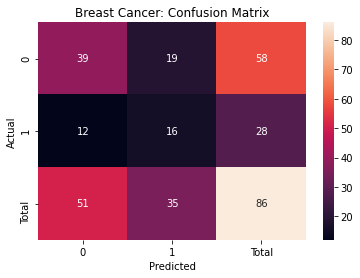

Accuracy
72.09302325581395


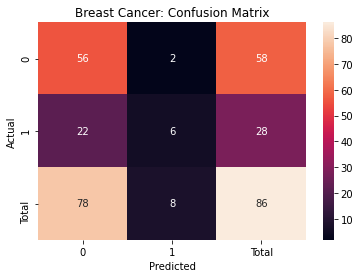

In [22]:
classifier_model = ID3(train_mix_classifier_dataset,train_mix_classifier_dataset)
classifier_model_accuray = decision_tree_acc(test_mix_classifier_dataset,classifier_model)


#Feature Selected
fs_classifier_model = ID3(train_mix_classifier_dataset[fs_features],train_mix_classifier_dataset[fs_features])
fs_classifier_model_accuray = decision_tree_acc(test_mix_classifier_dataset[fs_features],fs_drop_model)

<h3> Visualisations </h3>

In [351]:
import Dataset

<h3> Occurence of Target Values </h3>

<h3> Feature Contribution </h3>

/home/molefe/Learning/Wits/Machine Learning/Machine Learning: Assignment/machine-learning/machine_learning_assignment/src/Dataset.py:220: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = l3.transform(X[feature])


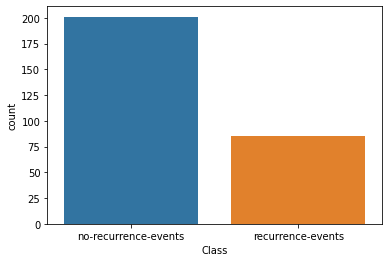

In [352]:
visualise = Dataset.Visualize(csv)
visualise.count_plot()


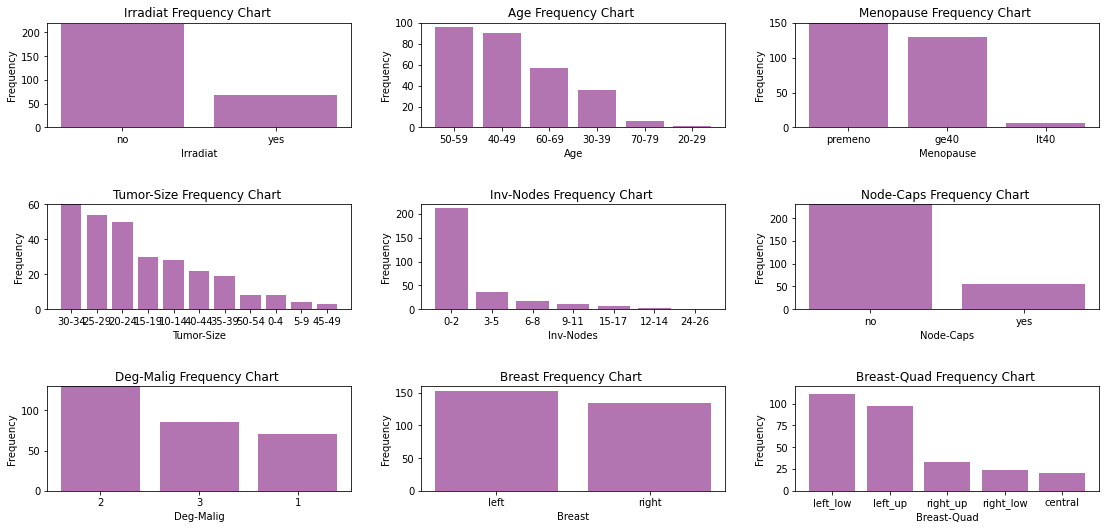

Irradiat : 6.3388446239978045
Age : 1.6681267347473179
Menopause : 1.2394169503360393
Tumor-Size : 8.07151853563732
Inv-Nodes : 43.48624421750894
Node-Caps : 15.500905854794308
Deg-Malig : 7.1197468203184435
Breast : 1.4604670881183062
Breast-Quad : 0.23111504535453187


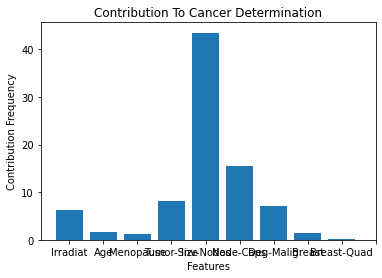

In [354]:
visualise.multi_barplot()
visualise.feature_contribution()